# Air Quality Data Analysis
# --------------------------
# This script is for air pollution data for NYC from OpenWeatherMap's API and performs analysis.

# Importing necessary libraries

In [1]:
import requests
import pandas as pd
import os
from datetime import datetime, timedelta
from pytz import timezone
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# -----------------------------------------------
# Section 1: Fetching Air Quality Data
# -----------------------------------------------
# Method to fetch air pollution data from OpenWeatherMap API for a given range of timestamps

In [2]:

def fetch_air_quality_data(latitude, longitude, timestamps, api_key):
    url = 'http://api.openweathermap.org/data/2.5/air_pollution/history'
    all_data = pd.DataFrame()

    for timestamp in timestamps:
        params = {
            'lat': latitude,
            'lon': longitude,
            'start': int(timestamp),
            'end': int(timestamp) + 3600,
            'appid': api_key,
        }
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            if 'list' in data and data['list']:
                air_quality_data = data['list'][0]

                components_df = pd.json_normalize(air_quality_data['components'])
                main_df = pd.json_normalize(air_quality_data['main'])

                timestamp = air_quality_data['dt']
                datetime_obj = datetime.fromtimestamp(timestamp, timezone('US/Eastern'))
                main_df['timestamp'] = datetime_obj

                row_data = pd.concat([main_df, components_df], axis=1)
                all_data = pd.concat([all_data, row_data], ignore_index=True)
        else:
            print(f"Error fetching data for timestamp {timestamp}: {response.status_code}")
            print(response.text)

    return all_data

# Setting up API key and coordinates for city

In [3]:

API_KEY = '2096402e6b2e9c5d1df834e67fe5070b'
latitude = '40.7127281' #coordinates for NYC
longitude = '-74.0060152'
eastern_time_zone = timezone('US/Eastern')
current_time = datetime.now(eastern_time_zone)
timestamps = [(current_time - timedelta(hours=i)).timestamp() for i in range(10)]

# Fetching the data

In [4]:
data = fetch_air_quality_data(latitude, longitude, timestamps, API_KEY)
data['timestamp'] = data['timestamp'].dt.tz_localize(None)  # Removing timezone for compatibility

# -----------------------------------------------
# Section 2: Saving Data to Files
# -----------------------------------------------
# Saving the fetched data to CSV and Excel files

In [5]:

def save_data_to_files(data):
    data.to_csv('air_quality_data_last_10_hours.csv', index=False)
    print("CSV file saved successfully.")
    data.to_excel('air_quality_data_last_10_hours.xlsx', index=False, engine='openpyxl')
    print("Excel file saved successfully.")
    os.startfile('air_quality_data_last_10_hours.xlsx')

save_data_to_files(data)

CSV file saved successfully.
Excel file saved successfully.


# -----------------------------------------------
# Section 3: Plotting Bar Chart for Last Hour
# -----------------------------------------------
# Plotting bar chart for pollutant levels in the last hour

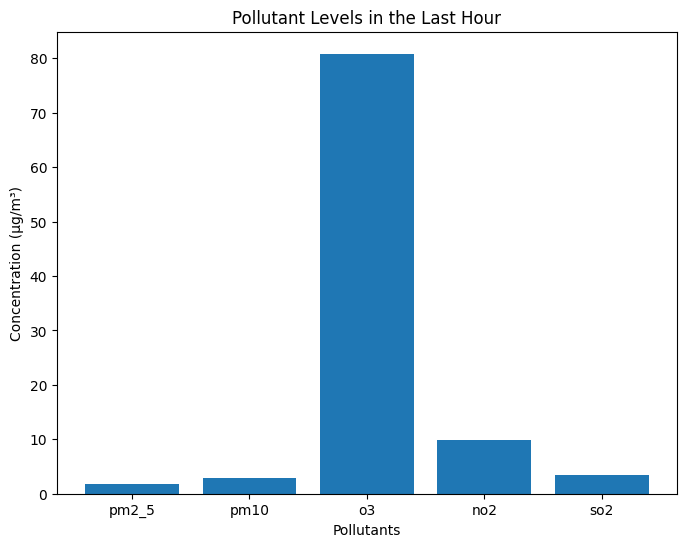

In [6]:

def plot_last_hour(data):
    last_hour_data = data.iloc[-1]
    components = ['pm2_5', 'pm10', 'o3', 'no2', 'so2']
    last_hour_values = last_hour_data[components]

    plt.figure(figsize=(8, 6))
    plt.bar(components, last_hour_values)
    plt.xlabel('Pollutants')
    plt.ylabel('Concentration (µg/m³)')
    plt.title('Pollutant Levels in the Last Hour')
    plt.show()

plot_last_hour(data)

# -----------------------------------------------
# Section 4: Correlation Heatmap
# -----------------------------------------------
# Computing and plotting a heatmap of correlations between pollutants

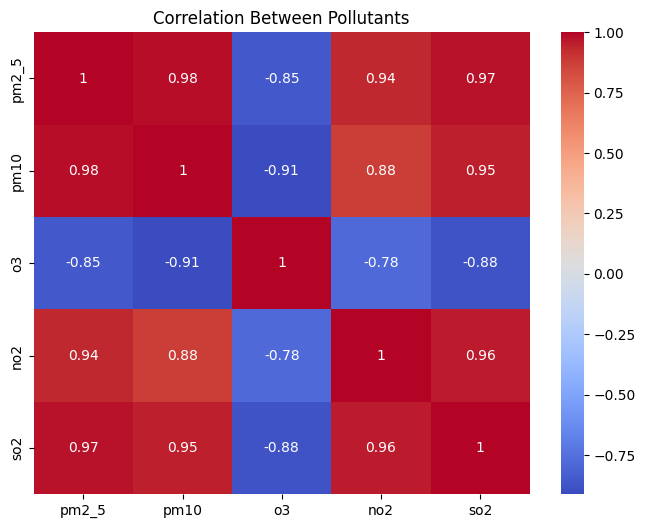

In [7]:

def plot_correlation_heatmap(data):
    corr = data[['pm2_5', 'pm10', 'o3', 'no2', 'so2']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Between Pollutants')
    plt.show()

plot_correlation_heatmap(data)

# -----------------------------------------------
# Section 5: Time Series Analysis
# -----------------------------------------------
# Interactive graph of pollutant levels over time

In [8]:
def plot_time_series(data):
    fig = px.line(
        data.reset_index(),
        x='timestamp',
        y=['pm2_5', 'pm10', 'o3', 'no2', 'so2'],
        title='Air Quality Over the Last 10 Hours',
        labels={'value': 'Concentration (µg/m³)', 'timestamp': 'Time'},
    )
    fig.update_layout(legend_title_text='Pollutants')
    fig.show()

plot_time_series(data)

# -----------------------------------------------
# Section 6: Threshold Analysis and Line Plots
# -----------------------------------------------
# Plotting pollutant levels with thresholds

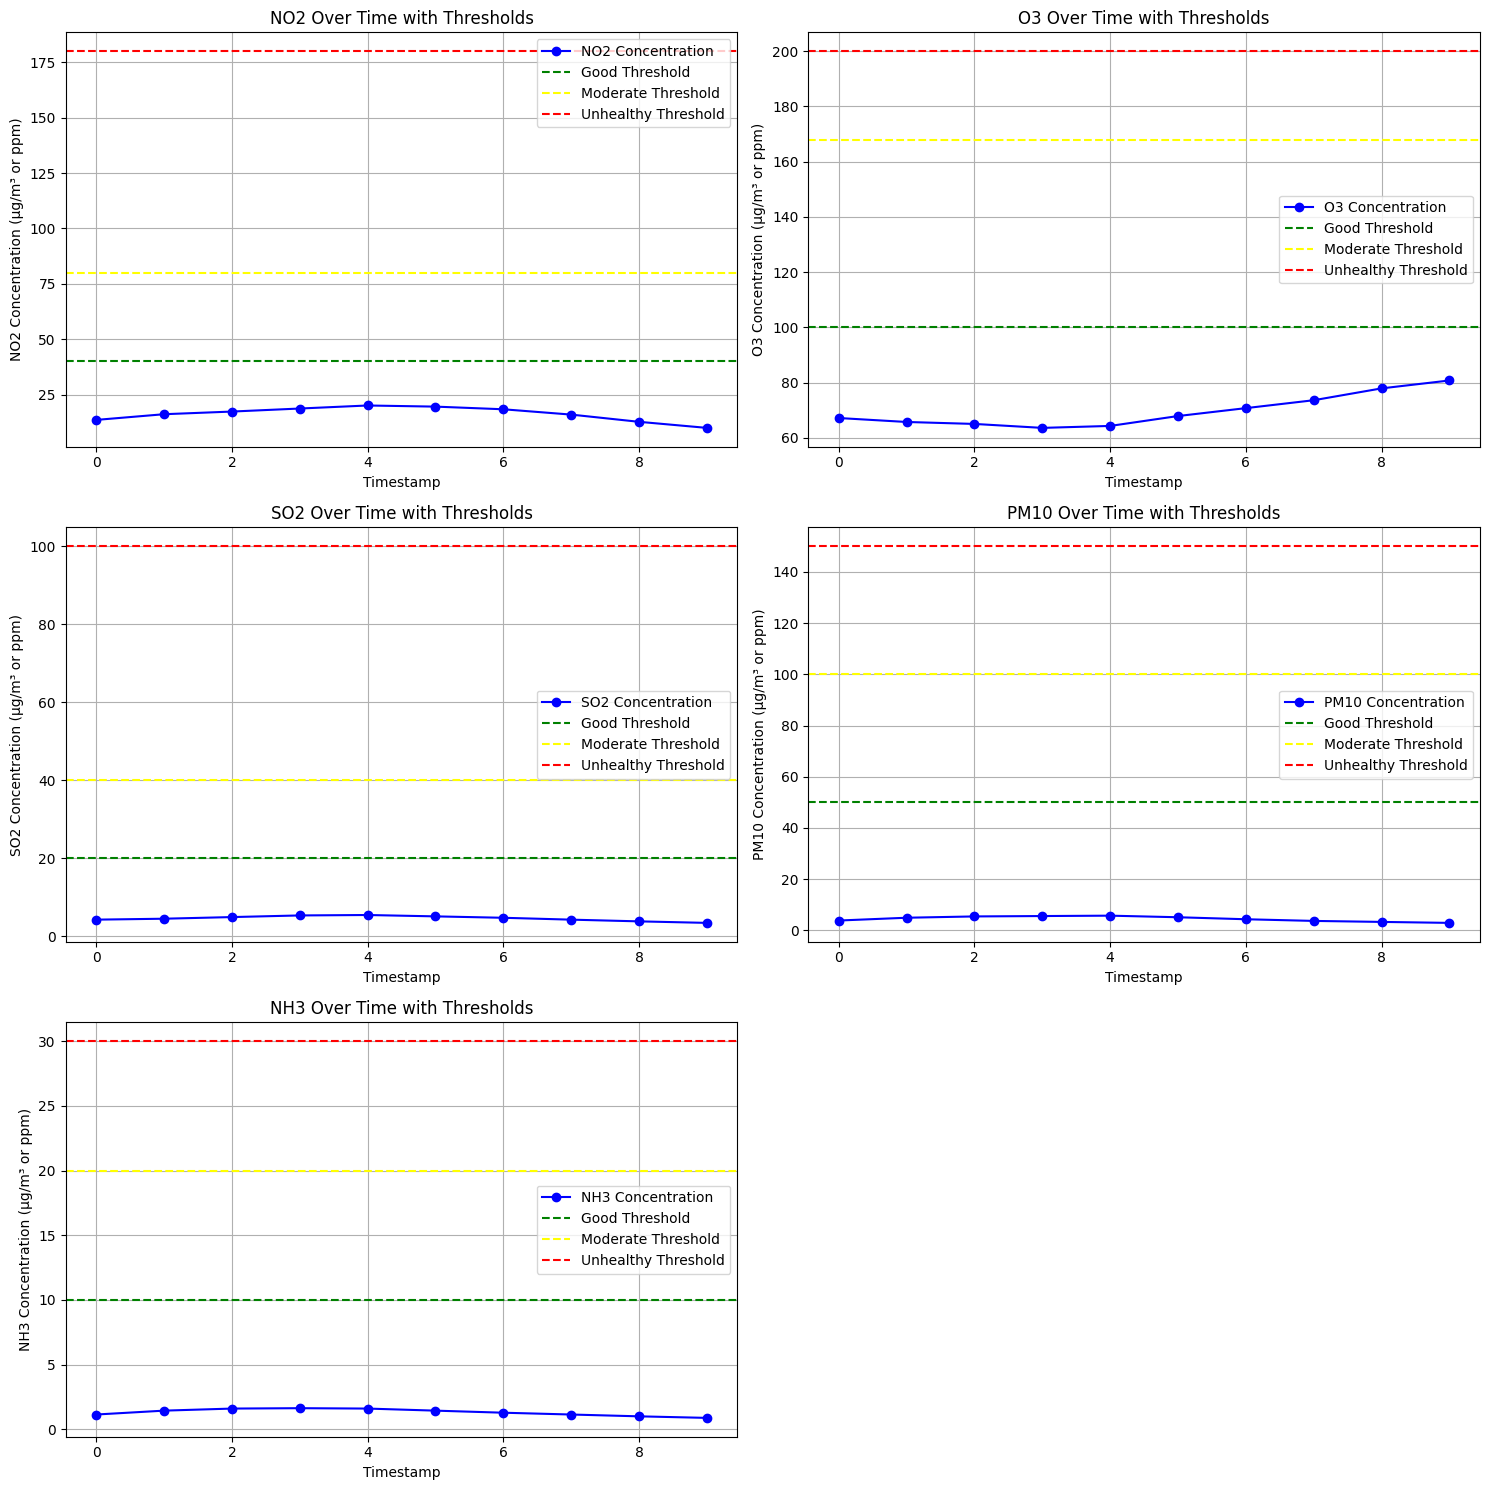

In [12]:
import matplotlib.pyplot as plt

def plot_pollutant_thresholds(data):
    # Define thresholds
    thresholds = {
        'no2': [40, 80, 180],
        'o3': [100, 168, 200],
        'so2': [20, 40, 100],
        'pm10': [50, 100, 150],
        'nh3': [10, 20, 30]
    }

    # Number of pollutants
    num_pollutants = len(thresholds)
    
    # Determine the number of rows and columns for subplots
    cols = 2  # Number of columns
    rows = (num_pollutants + 1) // cols  # Calculate rows dynamically
    
    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()  # Flatten to iterate easily

    for idx, (pollutant, levels) in enumerate(thresholds.items()):
        ax = axes[idx]  # Get the subplot axis
        
        # Plot pollutant data
        ax.plot(data.index, data[pollutant], label=f'{pollutant.upper()} Concentration', marker='o', color='blue')
        ax.axhline(y=levels[0], color='green', linestyle='--', label='Good Threshold')
        ax.axhline(y=levels[1], color='yellow', linestyle='--', label='Moderate Threshold')
        ax.axhline(y=levels[2], color='red', linestyle='--', label='Unhealthy Threshold')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel(f'{pollutant.upper()} Concentration (µg/m³ or ppm)')
        ax.set_title(f'{pollutant.upper()} Over Time with Thresholds')
        ax.legend()
        ax.grid()

    # Turn off unused axes if any
    for idx in range(len(thresholds), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# Call the function
plot_pollutant_thresholds(data)


# Additional combined pollutant graph

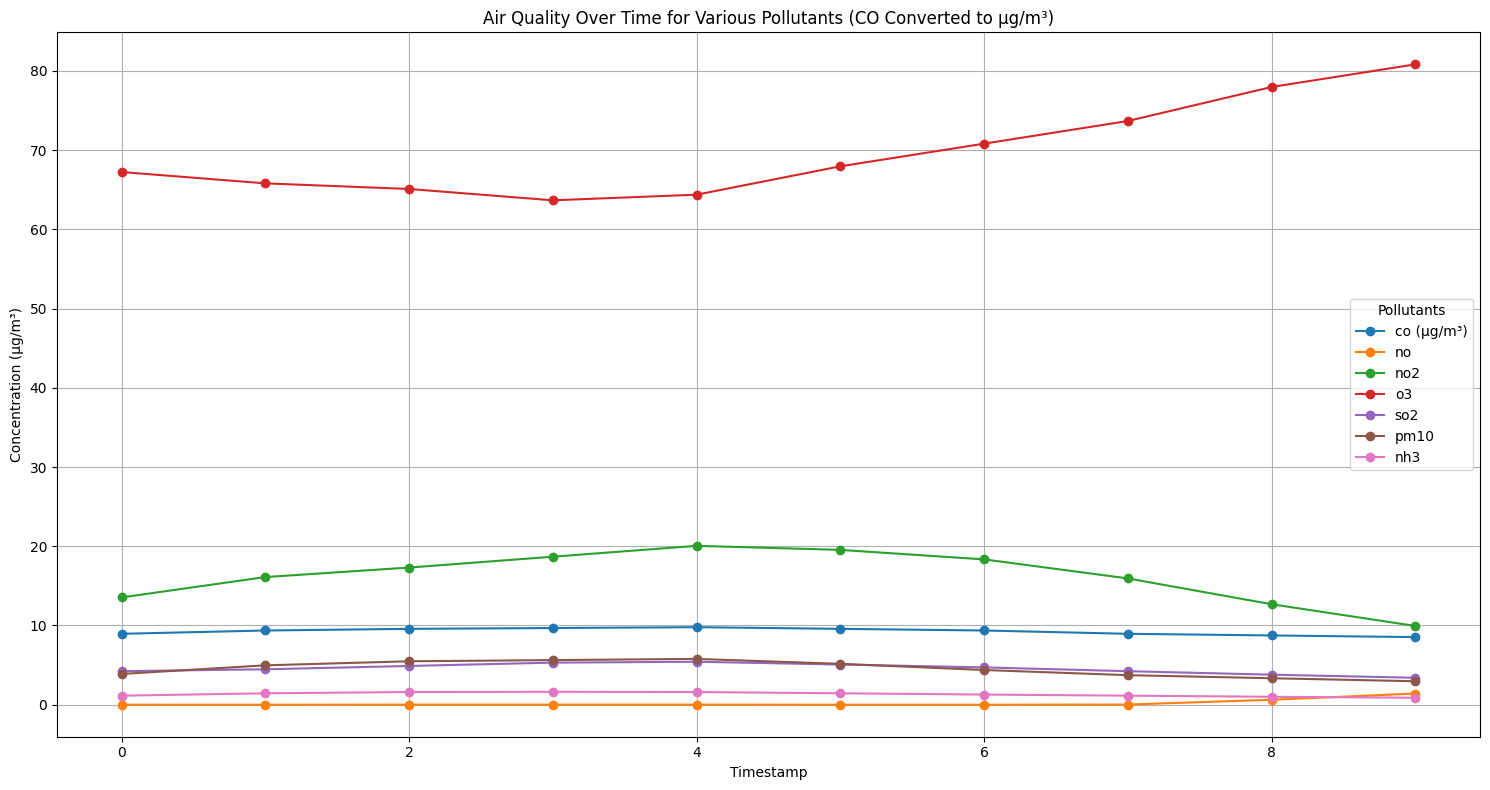

In [11]:
def plot_combined_pollutants(data):
    if 'co' in data.columns:
        data['co_converted'] = data['co'] / 32.076
    pollutants = ['co_converted', 'no', 'no2', 'o3', 'so2', 'pm10', 'nh3']

    plt.figure(figsize=(15, 8))
    for pollutant in pollutants:
        if pollutant in data.columns:
            plt.plot(data.index, data[pollutant], label=pollutant.replace('co_converted', 'co (µg/m³)'), marker='o')
    plt.xlabel('Timestamp')
    plt.ylabel('Concentration (µg/m³)')
    plt.title('Air Quality Over Time for Various Pollutants (CO Converted to µg/m³)')
    plt.legend(title='Pollutants')
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_combined_pollutants(data)
